In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.model_selection import train_test_split

df = pd.read_csv("dataframes/final_df.csv")
df.head()

,id,lat,lon,severity,borough_Barking and Dagenham,borough_Barnet,borough_Bexley,borough_Brent,borough_Bromley,borough_Camden,...,Car,Heavy_Vehicles,Motorcycle,Other,Pedalcycle,casualty_age_0-23,casualty_age_24-30,casualty_age_31-38,casualty_age_39-50,casualty_age_50+
0,345906,51.511963,-0.028211,0,0,0,0,0,0,0,...,2,0,0,0,0,0,1,0,0,0
1,345907,51.371636,-0.117621,0,0,0,0,0,0,0,...,2,0,0,0,0,0,0,0,1,0
2,345908,51.514951,-0.072747,0,0,0,0,0,0,0,...,0,0,1,0,1,0,1,0,0,0
3,345909,51.519173,-0.262356,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
4,345910,51.565743,-0.136308,0,0,0,0,0,0,0,...,1,0,1,0,0,1,0,0,0,0


Dropping Vehicle and Casualty related columns. Our analysis is going to focus on the features that can help us predict the cause of the accidents (location, hour, day_of_the_week,...). 
For this reason we discard columns related to the aftermath of the accidents.

In [2]:

df = df.drop(['Car', 'Heavy_Vehicles',
       'Motorcycle', 'Other', 'Pedalcycle', 'casualty_age_0-23',
       'casualty_age_24-30', 'casualty_age_31-38', 'casualty_age_39-50',
       'casualty_age_50+'], axis=1)
print(df.columns)

Index(['id', 'lat', 'lon', 'severity', 'borough_Barking and Dagenham',
       'borough_Barnet', 'borough_Bexley', 'borough_Brent', 'borough_Bromley',
       'borough_Camden', 'borough_City of London',
       'borough_City of Westminster', 'borough_Croydon', 'borough_Ealing',
       'borough_Enfield', 'borough_Greenwich', 'borough_Hackney',
       'borough_Hammersmith and Fulham', 'borough_Haringey', 'borough_Harrow',
       'borough_Havering', 'borough_Hillingdon', 'borough_Hounslow',
       'borough_Islington', 'borough_Kensington and Chelsea',
       'borough_Kingston', 'borough_Lambeth', 'borough_Lewisham',
       'borough_Merton', 'borough_Newham', 'borough_Redbridge',
       'borough_Richmond upon Thames', 'borough_Southwark', 'borough_Sutton',
       'borough_Tower Hamlets', 'borough_Waltham Forest', 'borough_Wandsworth',
       'time_of_day_Night', 'time_of_day_Morning', 'time_of_day_Afternoon',
       'time_of_day_Evening', 'month', 'day_of_week'],
      dtype='object')


In [3]:
X = df.drop(columns=['severity', 'id'])
y = df['severity']  # Assicurati che sia numerico o mappato (1, 2, 3)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(40500, 41)
(10126, 41)
(40500,)
(10126,)


## XGBClassifier

In [4]:
random_state=42

base_xgb_model_no_sample_weight = XGBClassifier(random_state=random_state)
base_xgb_model_no_sample_weight.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

              precision    recall  f1-score   support

           0      0.849     0.998     0.917      8547
           1      0.766     0.039     0.074      1527
           2      1.000     0.058     0.109        52

    accuracy                          0.848     10126
   macro avg      0.872     0.365     0.367     10126
weighted avg      0.837     0.848     0.786     10126



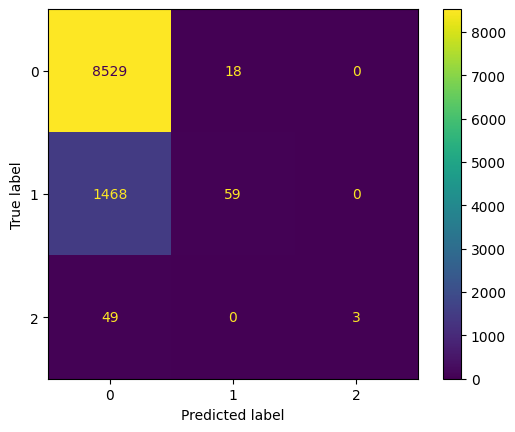

In [5]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

y_pred = base_xgb_model_no_sample_weight.predict(X_test)

print(classification_report(y_test, y_pred, digits=3))

cm=confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm)

disp.plot()
plt.show()

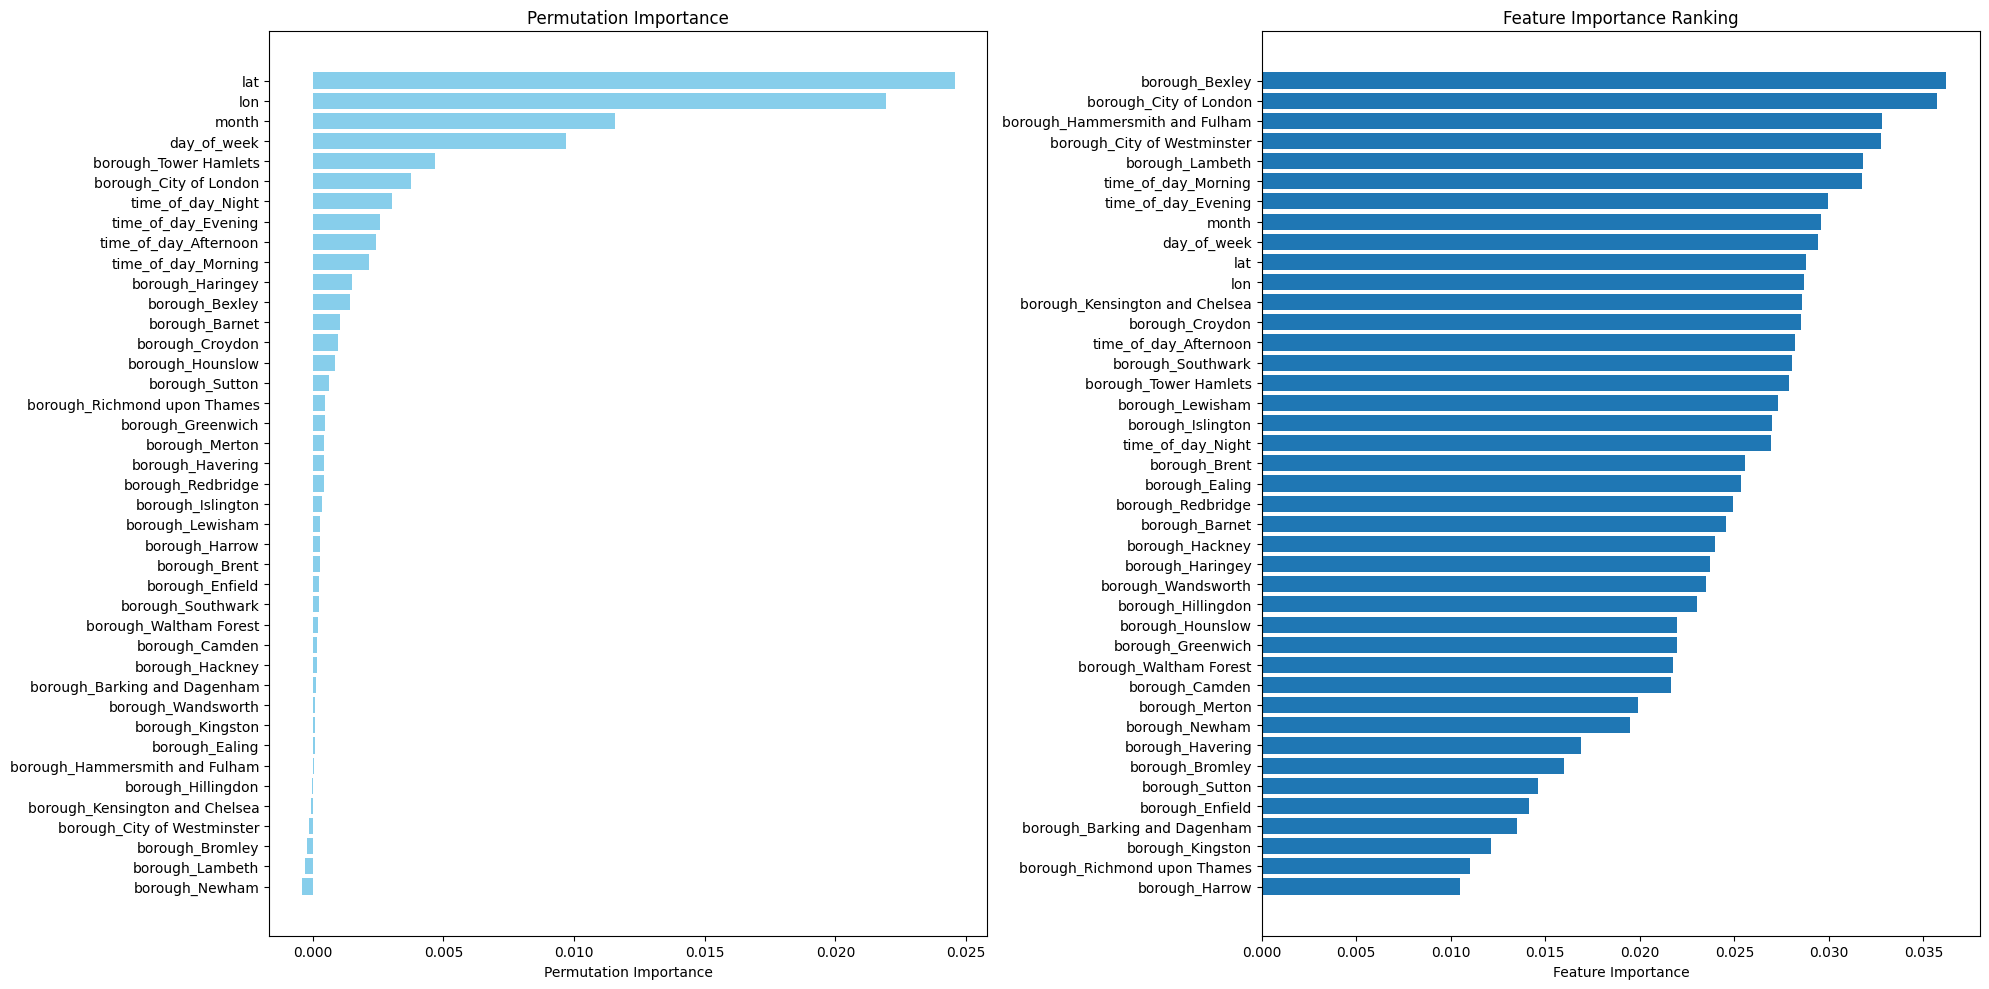

In [6]:
from sklearn.inspection import permutation_importance
feature_importance = base_xgb_model_no_sample_weight.feature_importances_

r_train = permutation_importance(base_xgb_model_no_sample_weight, X_train, y_train, n_repeats=30, random_state=42)
xbm_p_imp = pd.Series(index=X.columns, data=r_train.importances_mean)

sorted_idx = r_train.importances_mean.argsort()

# Assuming X_train.columns and feature importance arrays are defined
sorted_idx_perm = np.argsort(r_train.importances_mean)
sorted_idx_feat = np.argsort(feature_importance)

# Create subplots: 1 row, 2 columns
fig, axes = plt.subplots(1, 2, figsize=(20, 10))  # Adjust figure size as needed

# First plot: Permutation Importance
axes[0].barh(X_train.columns[sorted_idx_perm], r_train.importances_mean[sorted_idx_perm], color="skyblue")
axes[0].set_xlabel("Permutation Importance")
axes[0].set_title("Permutation Importance")

# Second plot: Feature Importance
axes[1].barh(X_train.columns[sorted_idx_feat], feature_importance[sorted_idx_feat])
axes[1].set_xlabel("Feature Importance")
axes[1].set_title("Feature Importance Ranking")

# Adjust layout for readability
plt.tight_layout()
plt.show()

# plt.figure(figsize=(16, 16))
# plt.barh(X_train.columns[sorted_idx], r_train.importances_mean[sorted_idx], color="skyblue")
# plt.xlabel("Permutation Importance")
# plt.title("Feature Importance via Permutation")
# plt.show()

# plt.figure(figsize=(20,20))
# sorted_idx = np.argsort(feature_importance)
# plt.barh(X_train.columns[sorted_idx], feature_importance[sorted_idx])
# plt.xlabel("Feature Importance")
# plt.show()

In [13]:
from sklearn.metrics import roc_auc_score

 
y_proba      = base_xgb_model_no_sample_weight.predict_proba(X_test)
xbm_score_test = roc_auc_score(y_test, y_proba, multi_class='ovr')


print(f'AUC score {xbm_score_test:.2f} (test)')

AUC score 0.79 (test)


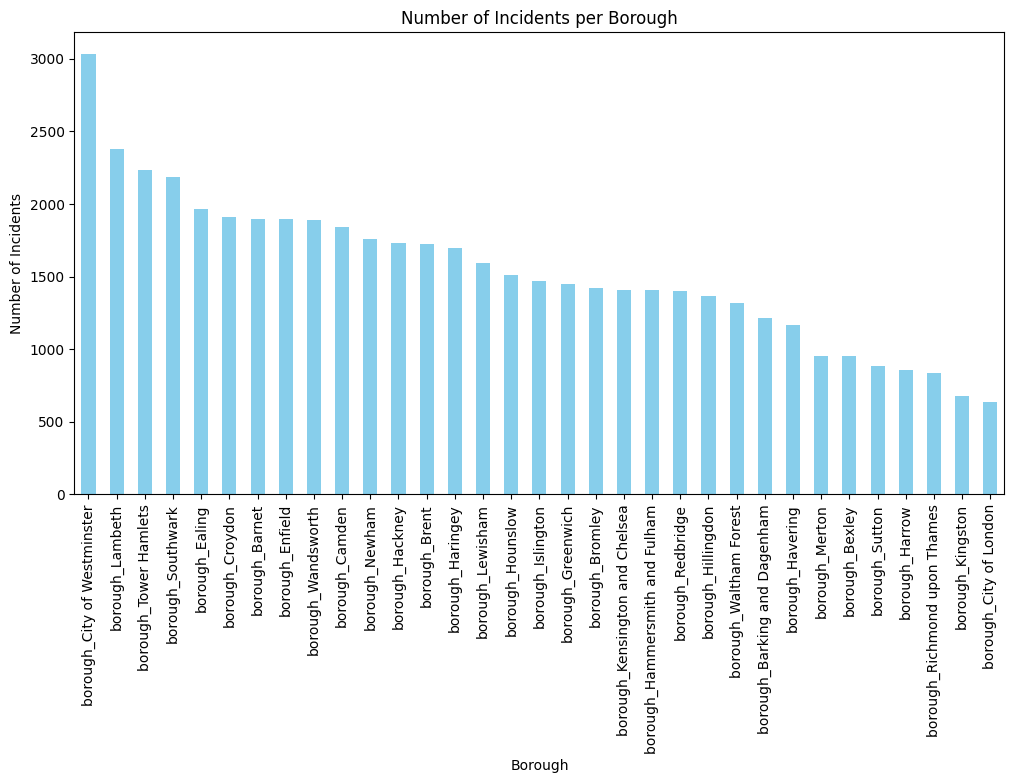

In [7]:
import matplotlib.pyplot as plt

def plot_incidents_by_borough(df):
    borough_cols = [col for col in df.columns if col.startswith("borough_")]
    borough_counts = df[borough_cols].sum().sort_values(ascending=False)

    plt.figure(figsize=(12, 6))
    borough_counts.plot(kind="bar", color="skyblue")
    plt.xticks(rotation=90)
    plt.xlabel("Borough")
    plt.ylabel("Number of Incidents")
    plt.title("Number of Incidents per Borough")
    plt.show()

# Esempio di utilizzo
plot_incidents_by_borough(df)

As we can see, Permutation Importance on the boroughs is not very reliable.

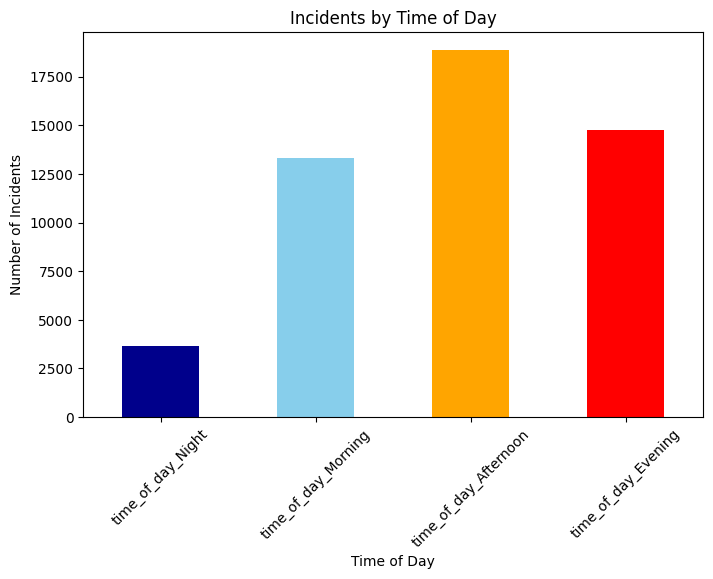

In [8]:
import matplotlib.pyplot as plt

def plot_incidents_by_time_of_day(df):
    time_of_day_cols = ['time_of_day_Night', 'time_of_day_Morning', 'time_of_day_Afternoon', 'time_of_day_Evening']
    
    # Conta gli incidenti per ogni fascia oraria
    incidents_count = df[time_of_day_cols].sum()
    
    # Plot
    plt.figure(figsize=(8,5))
    incidents_count.plot(kind='bar', color=['darkblue', 'skyblue', 'orange', 'red'])
    plt.xlabel("Time of Day")
    plt.ylabel("Number of Incidents")
    plt.title("Incidents by Time of Day")
    plt.xticks(rotation=45)
    plt.show()

# Chiamare la funzione passando il dataframe
plot_incidents_by_time_of_day(df)


## XGBClassifier using Sample Weights

In [9]:
random_state=42

sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=y_train
)

base_xgb_model = XGBClassifier(random_state=random_state)
base_xgb_model.fit(X_train, y_train, sample_weight=sample_weights)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

              precision    recall  f1-score   support

           0      0.914     0.746     0.821      8547
           1      0.309     0.606     0.409      1527
           2      0.288     0.808     0.424        52

    accuracy                          0.725     10126
   macro avg      0.503     0.720     0.552     10126
weighted avg      0.819     0.725     0.757     10126



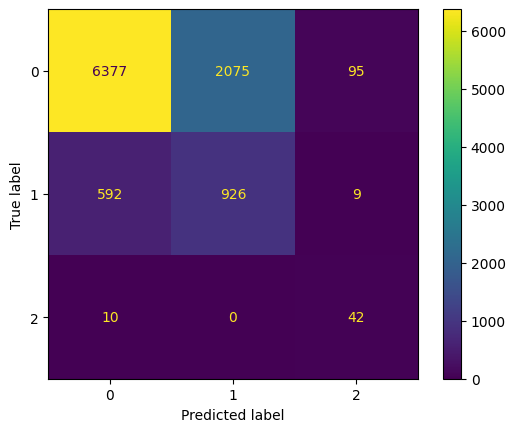

In [10]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

y_pred = base_xgb_model.predict(X_test)

print(classification_report(y_test, y_pred, digits=3))

cm=confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm)

disp.plot()
plt.show()

Printing Feature Importance from XGBoost and Permutation Importance.

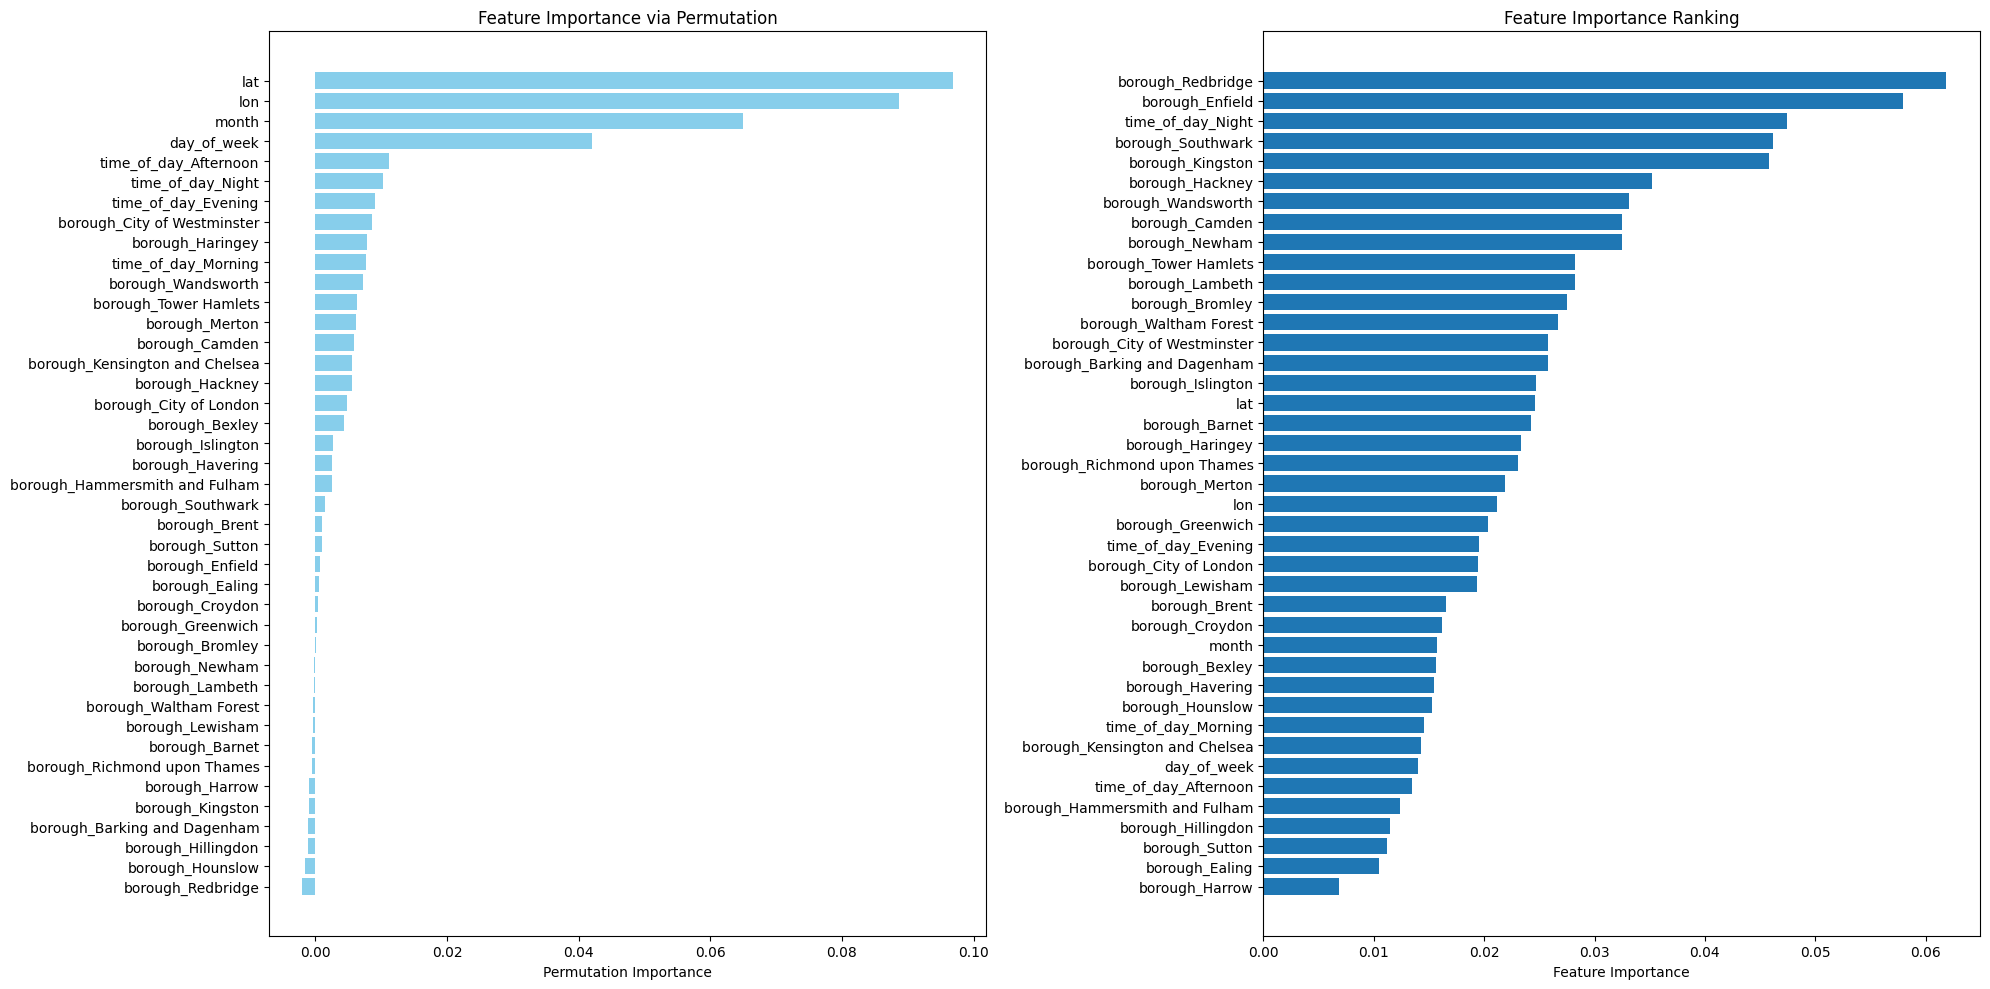

In [11]:
from sklearn.inspection import permutation_importance
feature_importance = base_xgb_model.feature_importances_

r_train = permutation_importance(base_xgb_model, X_train, y_train, n_repeats=30, random_state=42)
xbm_p_imp = pd.Series(index=X.columns, data=r_train.importances_mean)

sorted_idx = r_train.importances_mean.argsort()

# Assuming X_train.columns and feature importance arrays are defined
sorted_idx_perm = np.argsort(r_train.importances_mean)
sorted_idx_feat = np.argsort(feature_importance)

# Create subplots: 1 row, 2 columns
fig, axes = plt.subplots(1, 2, figsize=(20, 10))  # Adjust figure size as needed

# First plot: Permutation Importance
axes[0].barh(X_train.columns[sorted_idx_perm], r_train.importances_mean[sorted_idx_perm], color="skyblue")
axes[0].set_xlabel("Permutation Importance")
axes[0].set_title("Feature Importance via Permutation")

# Second plot: Feature Importance
axes[1].barh(X_train.columns[sorted_idx_feat], feature_importance[sorted_idx_feat])
axes[1].set_xlabel("Feature Importance")
axes[1].set_title("Feature Importance Ranking")

# Adjust layout for readability
plt.tight_layout()
plt.show()

# plt.figure(figsize=(16, 16))
# plt.barh(X_train.columns[sorted_idx], r_train.importances_mean[sorted_idx], color="skyblue")
# plt.xlabel("Permutation Importance")
# plt.title("Feature Importance via Permutation")
# plt.show()

# plt.figure(figsize=(20,20))
# sorted_idx = np.argsort(feature_importance)
# plt.barh(X_train.columns[sorted_idx], feature_importance[sorted_idx])
# plt.xlabel("Feature Importance")
# plt.show()

In [12]:
from sklearn.metrics import roc_auc_score

 
y_proba      = base_xgb_model.predict_proba(X_test)
xbm_score_test = roc_auc_score(y_test, y_proba, multi_class='ovr')


print(f'AUC score {xbm_score_test:.2f} (test)')

AUC score 0.79 (test)


## XGBClassifier using sample weights and ADASYN for resampling

We also applied some GridSearch to find the best hyperparameters for XGBoost.

In [21]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from imblearn.over_sampling import ADASYN
from sklearn.utils.class_weight import compute_sample_weight
import numpy as np
import pandas as pd

X = df.drop(columns=['severity', 'id'])
y = df['severity']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

adasyn = ADASYN(random_state=42)
X_res, y_res = adasyn.fit_resample(X_train, y_train)

sample_weights = compute_sample_weight(class_weight='balanced', y=y_res)

param_grid = {
    'learning_rate': [0.3, 0.4, 0.5],
    'max_depth': [15,20,25],
    'subsample': [0.6, 0.8],
    # 'colsample_bytree': [0.6, 0.8, 1.0],
    # 'n_estimators': [100, 200, 300],
    # 'gamma': [0, 0.1, 0.2],
    # 'reg_alpha': [0.0, 0.1, 1.0],
    # 'reg_lambda': [1.0, 1.5, 2.0],
}

xgb_model = XGBClassifier(
    objective='multi:softprob',
    num_class=len(np.unique(y)),
    eval_metric='mlogloss',
    random_state=42,
    n_jobs=-1
)

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='f1_macro',  
    cv=3,                
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_res, y_res, sample_weight=sample_weights)

print("\nBest Parameters:", grid_search.best_params_)
print("Best F1 Score:", grid_search.best_score_)

model_xgb_adysin = grid_search.best_estimator_


Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] END .....learning_rate=0.3, max_depth=15, subsample=0.8; total time=   4.9s
[CV] END .....learning_rate=0.3, max_depth=15, subsample=0.8; total time=   4.7s
[CV] END .....learning_rate=0.3, max_depth=15, subsample=0.6; total time=   5.1s
[CV] END .....learning_rate=0.3, max_depth=15, subsample=0.6; total time=   5.3s


/Users/aaronsalazar/LocalDocs/Bologna/ai_industry/.venv/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END .....learning_rate=0.3, max_depth=15, subsample=0.6; total time=   5.2s
[CV] END .....learning_rate=0.3, max_depth=15, subsample=0.8; total time=   5.1s
[CV] END .....learning_rate=0.3, max_depth=20, subsample=0.6; total time=   6.9s
[CV] END .....learning_rate=0.3, max_depth=20, subsample=0.6; total time=   7.4s
[CV] END .....learning_rate=0.3, max_depth=20, subsample=0.6; total time=   7.5s
[CV] END .....learning_rate=0.3, max_depth=20, subsample=0.8; total time=   7.2s


KeyboardInterrupt: 


Classification Report:
              precision    recall  f1-score   support

      Slight      0.968     0.962     0.965      8613
     Serious      0.784     0.820     0.802      1465
       Fatal      0.973     0.750     0.847        48

    accuracy                          0.940     10126
   macro avg      0.908     0.844     0.871     10126
weighted avg      0.941     0.940     0.941     10126



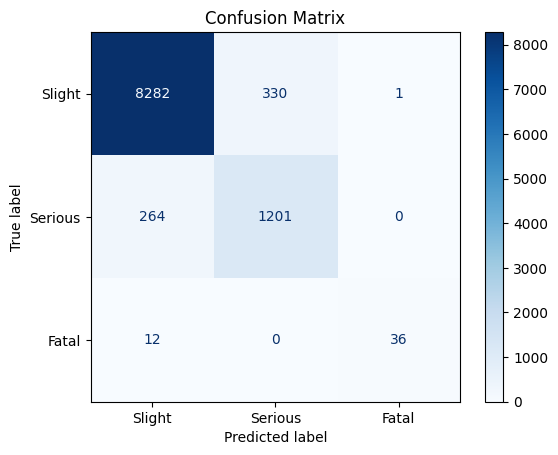

In [18]:
y_pred = model_xgb_adysin.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Slight', 'Serious', 'Fatal'], digits=3))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Slight', 'Serious', 'Fatal'])
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()

Computing ROC_AUC score for the model with the best parameter found.

In [19]:
from sklearn.metrics import roc_auc_score

xbm_score_cv = grid_search.best_score_  
y_proba      = model_xgb_adysin.predict_proba(X_test)
xbm_score_test = roc_auc_score(y_test, y_proba, multi_class='ovr')
xbm_params     = grid_search.best_params_

print(f'AUC score for {xbm_params}: {xbm_score_cv:.2f} (cross-val.), {xbm_score_test:.2f} (test)')

AUC score for {'learning_rate': 0.4, 'max_depth': 15, 'subsample': 0.8}: 0.91 (cross-val.), 0.91 (test)


Printing Feature Importance and Permutation Importance from the obtained model.

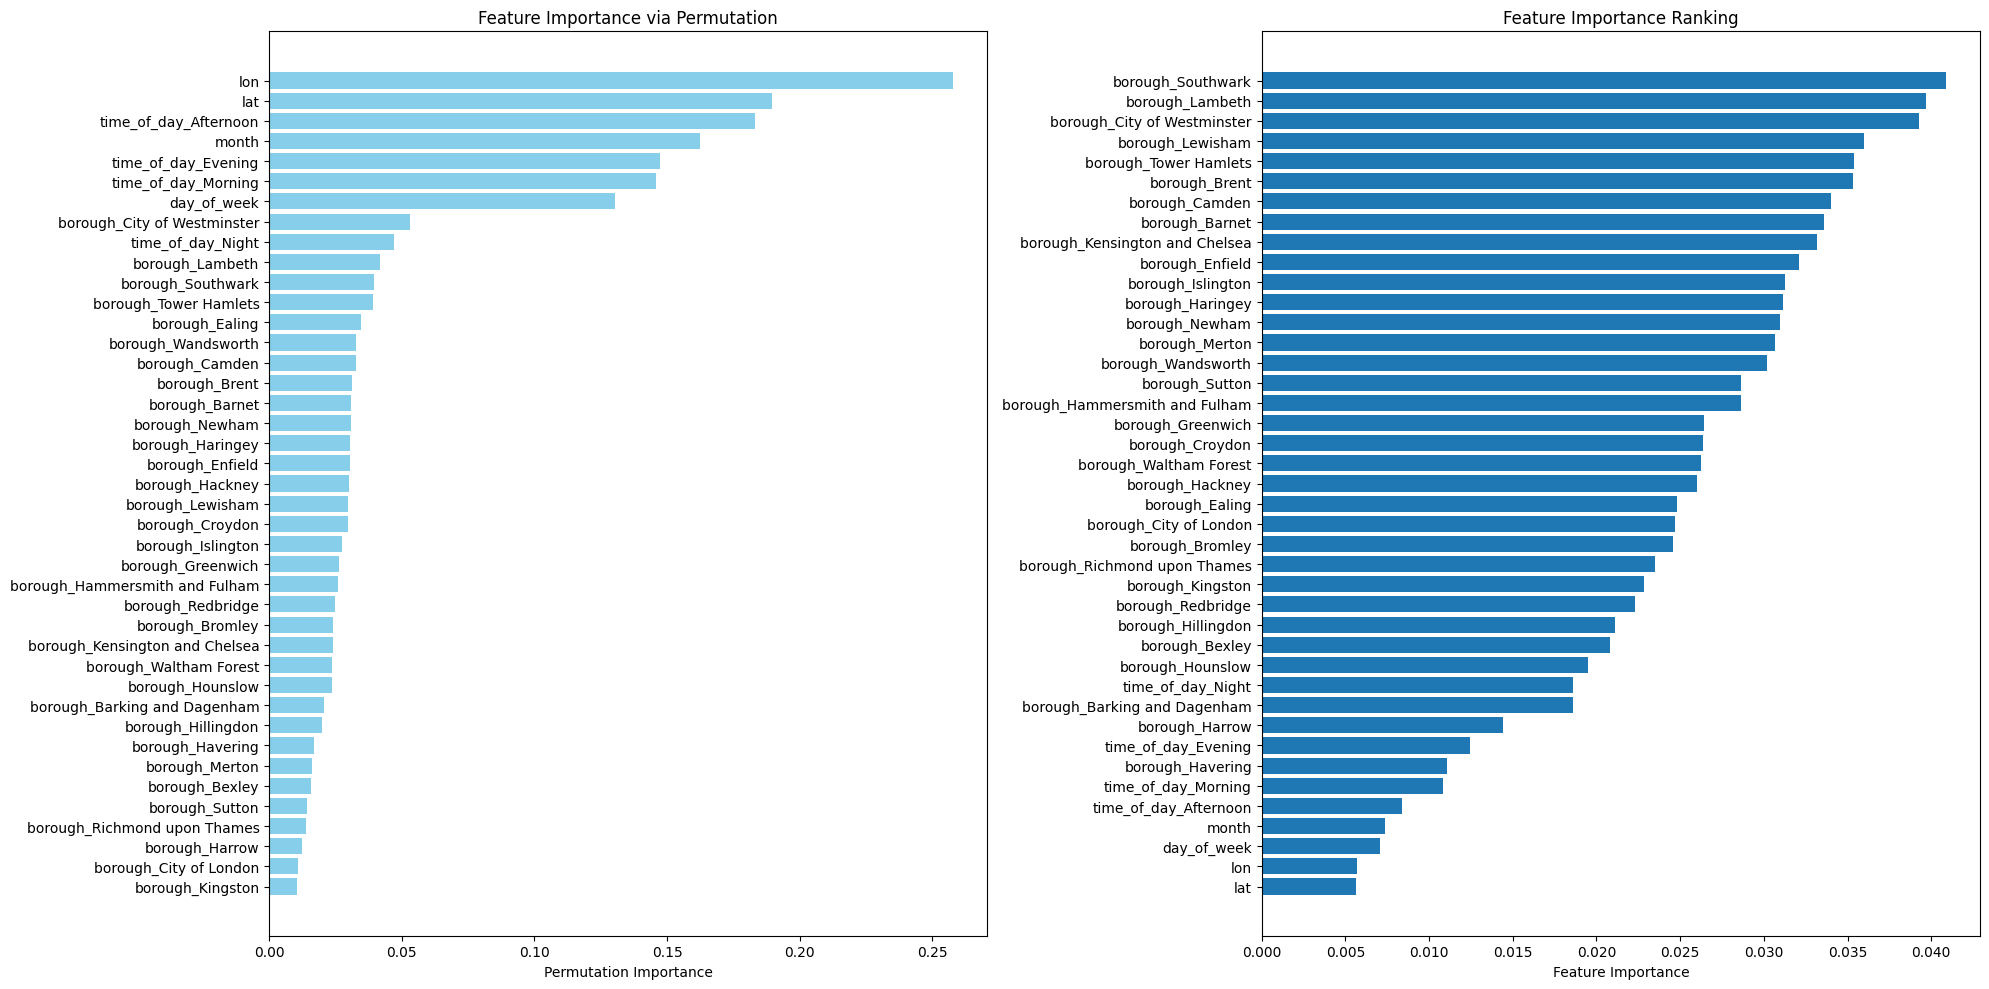

In [ ]:
from sklearn.inspection import permutation_importance

feature_importance = model_xgb_adysin.feature_importances_

r_train = permutation_importance(model_xgb_adysin, X_train, y_train, n_repeats=30, random_state=42)
xbm_p_imp = pd.Series(index=X.columns, data=r_train.importances_mean)

sorted_idx = r_train.importances_mean.argsort()

# Assuming X_train.columns and feature importance arrays are defined
sorted_idx_perm = np.argsort(r_train.importances_mean)
sorted_idx_feat = np.argsort(feature_importance)

# Create subplots: 1 row, 2 columns
fig, axes = plt.subplots(1, 2, figsize=(20, 10))  # Adjust figure size as needed

# First plot: Permutation Importance
axes[0].barh(X_train.columns[sorted_idx_perm], r_train.importances_mean[sorted_idx_perm], color="skyblue")
axes[0].set_xlabel("Permutation Importance")
axes[0].set_title("Feature Importance via Permutation")

# Second plot: Feature Importance
axes[1].barh(X_train.columns[sorted_idx_feat], feature_importance[sorted_idx_feat])
axes[1].set_xlabel("Feature Importance")
axes[1].set_title("Feature Importance Ranking")

# Adjust layout for readability
plt.tight_layout()
plt.show()
# plt.figure(figsize=(20,20))
# sorted_idx = np.argsort(feature_importance)
# plt.barh(X_train.columns[sorted_idx], feature_importance[sorted_idx])
# plt.xlabel("Feature Importance")
# plt.show()

#--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## RISK LEVEL ANALYSIS

In [35]:
from imblearn.over_sampling import ADASYN
from sklearn.utils.class_weight import compute_sample_weight
df_risk = pd.read_csv("Risk_level_Dataset.csv")
df_risk.head()

,id,lat,lon,severity,time_of_day_Night,time_of_day_Morning,time_of_day_Afternoon,time_of_day_Evening,month,day_of_week,risk_level_encoded
0,345906,51.511963,-0.028211,0,1,0,0,0,1,3,2
1,345907,51.371636,-0.117621,0,0,0,0,1,1,2,2
2,345908,51.514951,-0.072747,0,0,0,0,1,1,2,2
3,345909,51.519173,-0.262356,0,0,1,0,0,1,3,2
4,345910,51.565743,-0.136308,0,0,1,0,0,1,3,1


In [36]:
X = df_risk.drop(columns=['severity', 'id'])
y = df_risk['severity']  # Assicurati che sia numerico o mappato (1, 2, 3)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

adasyn = ADASYN(random_state=42)
X_res, y_res = adasyn.fit_resample(X_train, y_train)

sample_weights = compute_sample_weight(class_weight='balanced', y=y_res)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(40500, 9)
(10126, 9)
(40500,)
(10126,)


In [37]:
# {'learning_rate': 0.4, 'max_depth': 15, 'subsample': 0.8}:
risk_level_model = XGBClassifier(random_state=42,
                                 learning_rate = 0.4,
                                 max_depth = 15,
                                 subsample = 0.8)
risk_level_model.fit(X_res, y_res, sample_weight=sample_weights)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.4, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=15, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

              precision    recall  f1-score   support

           0      0.971     0.943     0.957      8613
           1      0.723     0.840     0.777      1465
           2      0.610     0.750     0.673        48

    accuracy                          0.927     10126
   macro avg      0.768     0.844     0.802     10126
weighted avg      0.934     0.927     0.930     10126



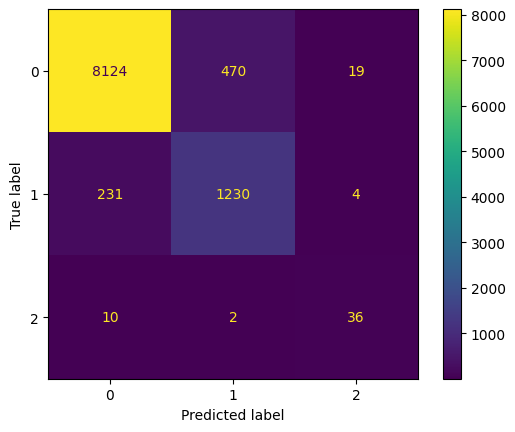

In [38]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

y_pred = risk_level_model.predict(X_test)

print(classification_report(y_test, y_pred, digits=3))

cm=confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm)

disp.plot()
plt.show()

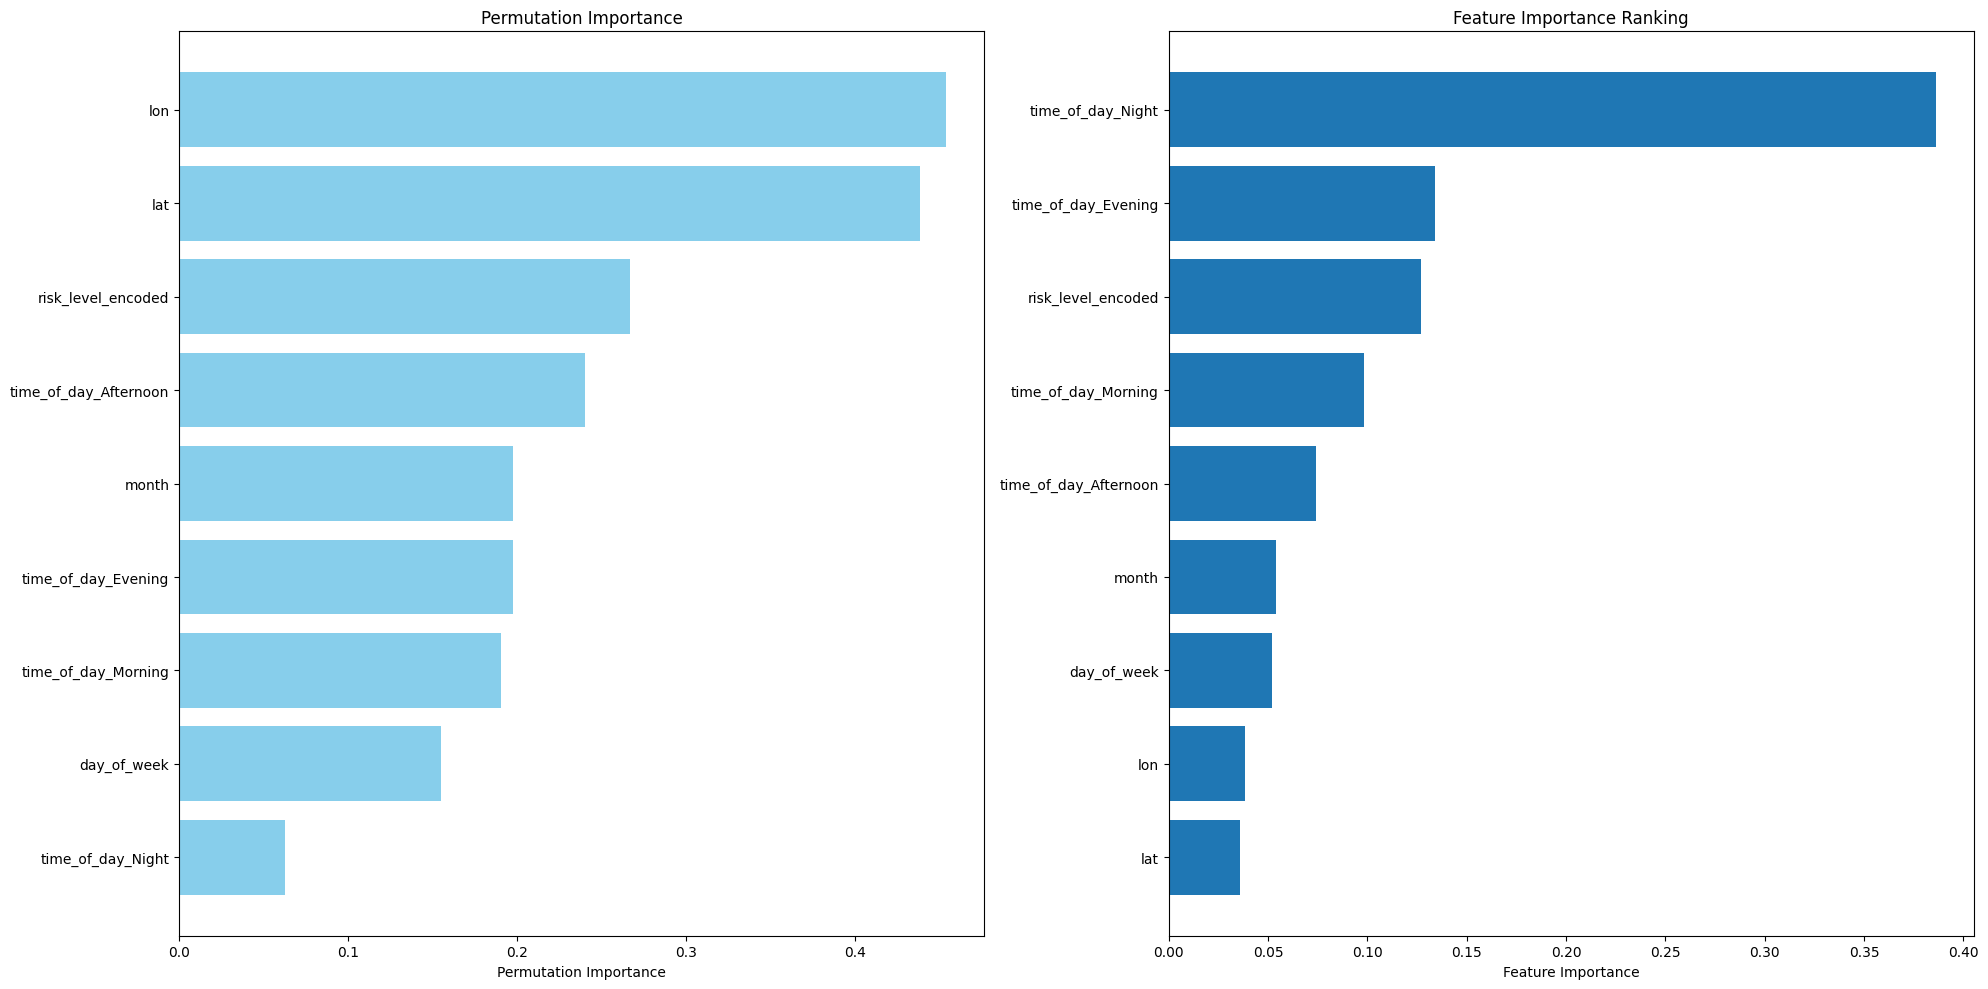

In [39]:
from sklearn.inspection import permutation_importance
feature_importance = risk_level_model.feature_importances_

r_train = permutation_importance(risk_level_model, X_train, y_train, n_repeats=30, random_state=42)
xbm_p_imp = pd.Series(index=X.columns, data=r_train.importances_mean)

sorted_idx = r_train.importances_mean.argsort()

# Assuming X_train.columns and feature importance arrays are defined
sorted_idx_perm = np.argsort(r_train.importances_mean)
sorted_idx_feat = np.argsort(feature_importance)

# Create subplots: 1 row, 2 columns
fig, axes = plt.subplots(1, 2, figsize=(20, 10))  # Adjust figure size as needed

# First plot: Permutation Importance
axes[0].barh(X_train.columns[sorted_idx_perm], r_train.importances_mean[sorted_idx_perm], color="skyblue")
axes[0].set_xlabel("Permutation Importance")
axes[0].set_title("Permutation Importance")

# Second plot: Feature Importance
axes[1].barh(X_train.columns[sorted_idx_feat], feature_importance[sorted_idx_feat])
axes[1].set_xlabel("Feature Importance")
axes[1].set_title("Feature Importance Ranking")

# Adjust layout for readability
plt.tight_layout()
plt.show()


In [45]:
df_risk_no_lat_lon = df_risk.copy()
df_risk_no_lat_lon.head()

,id,lat,lon,severity,time_of_day_Night,time_of_day_Morning,time_of_day_Afternoon,time_of_day_Evening,month,day_of_week,risk_level_encoded
0,345906,51.511963,-0.028211,0,1,0,0,0,1,3,2
1,345907,51.371636,-0.117621,0,0,0,0,1,1,2,2
2,345908,51.514951,-0.072747,0,0,0,0,1,1,2,2
3,345909,51.519173,-0.262356,0,0,1,0,0,1,3,2
4,345910,51.565743,-0.136308,0,0,1,0,0,1,3,1


In [46]:
df_risk_no_lat_lon.drop(columns=["lat", "lon"], inplace=True)
df_risk_no_lat_lon.head()

,id,severity,time_of_day_Night,time_of_day_Morning,time_of_day_Afternoon,time_of_day_Evening,month,day_of_week,risk_level_encoded
0,345906,0,1,0,0,0,1,3,2
1,345907,0,0,0,0,1,1,2,2
2,345908,0,0,0,0,1,1,2,2
3,345909,0,0,1,0,0,1,3,2
4,345910,0,0,1,0,0,1,3,1


In [47]:
X = df_risk_no_lat_lon.drop(columns=['severity', 'id'])
y = df_risk_no_lat_lon['severity']  # Assicurati che sia numerico o mappato (1, 2, 3)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

adasyn = ADASYN(random_state=42)
X_res, y_res = adasyn.fit_resample(X_train, y_train)

sample_weights = compute_sample_weight(class_weight='balanced', y=y_res)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(40500, 7)
(10126, 7)
(40500,)
(10126,)


In [48]:
# {'learning_rate': 0.4, 'max_depth': 15, 'subsample': 0.8}:
risk_level_model_no_lat_lon = XGBClassifier(random_state=42,
                                 learning_rate = 0.4,
                                 max_depth = 15,
                                 subsample = 0.8)
risk_level_model_no_lat_lon.fit(X_res, y_res, sample_weight=sample_weights)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.4, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=15, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

              precision    recall  f1-score   support

           0      0.879     0.457     0.601      8613
           1      0.172     0.520     0.259      1465
           2      0.018     0.458     0.035        48

    accuracy                          0.466     10126
   macro avg      0.356     0.479     0.298     10126
weighted avg      0.772     0.466     0.549     10126



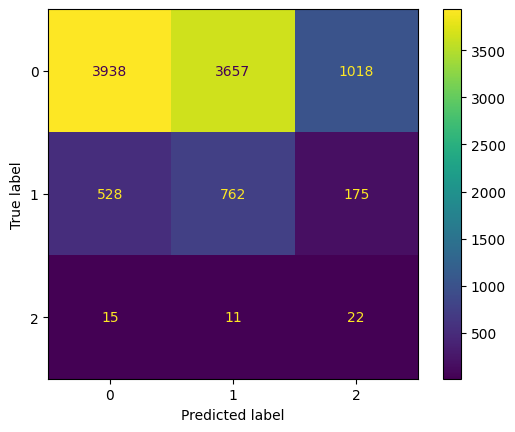

In [49]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

y_pred = risk_level_model_no_lat_lon.predict(X_test)

print(classification_report(y_test, y_pred, digits=3))

cm=confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm)

disp.plot()
plt.show()

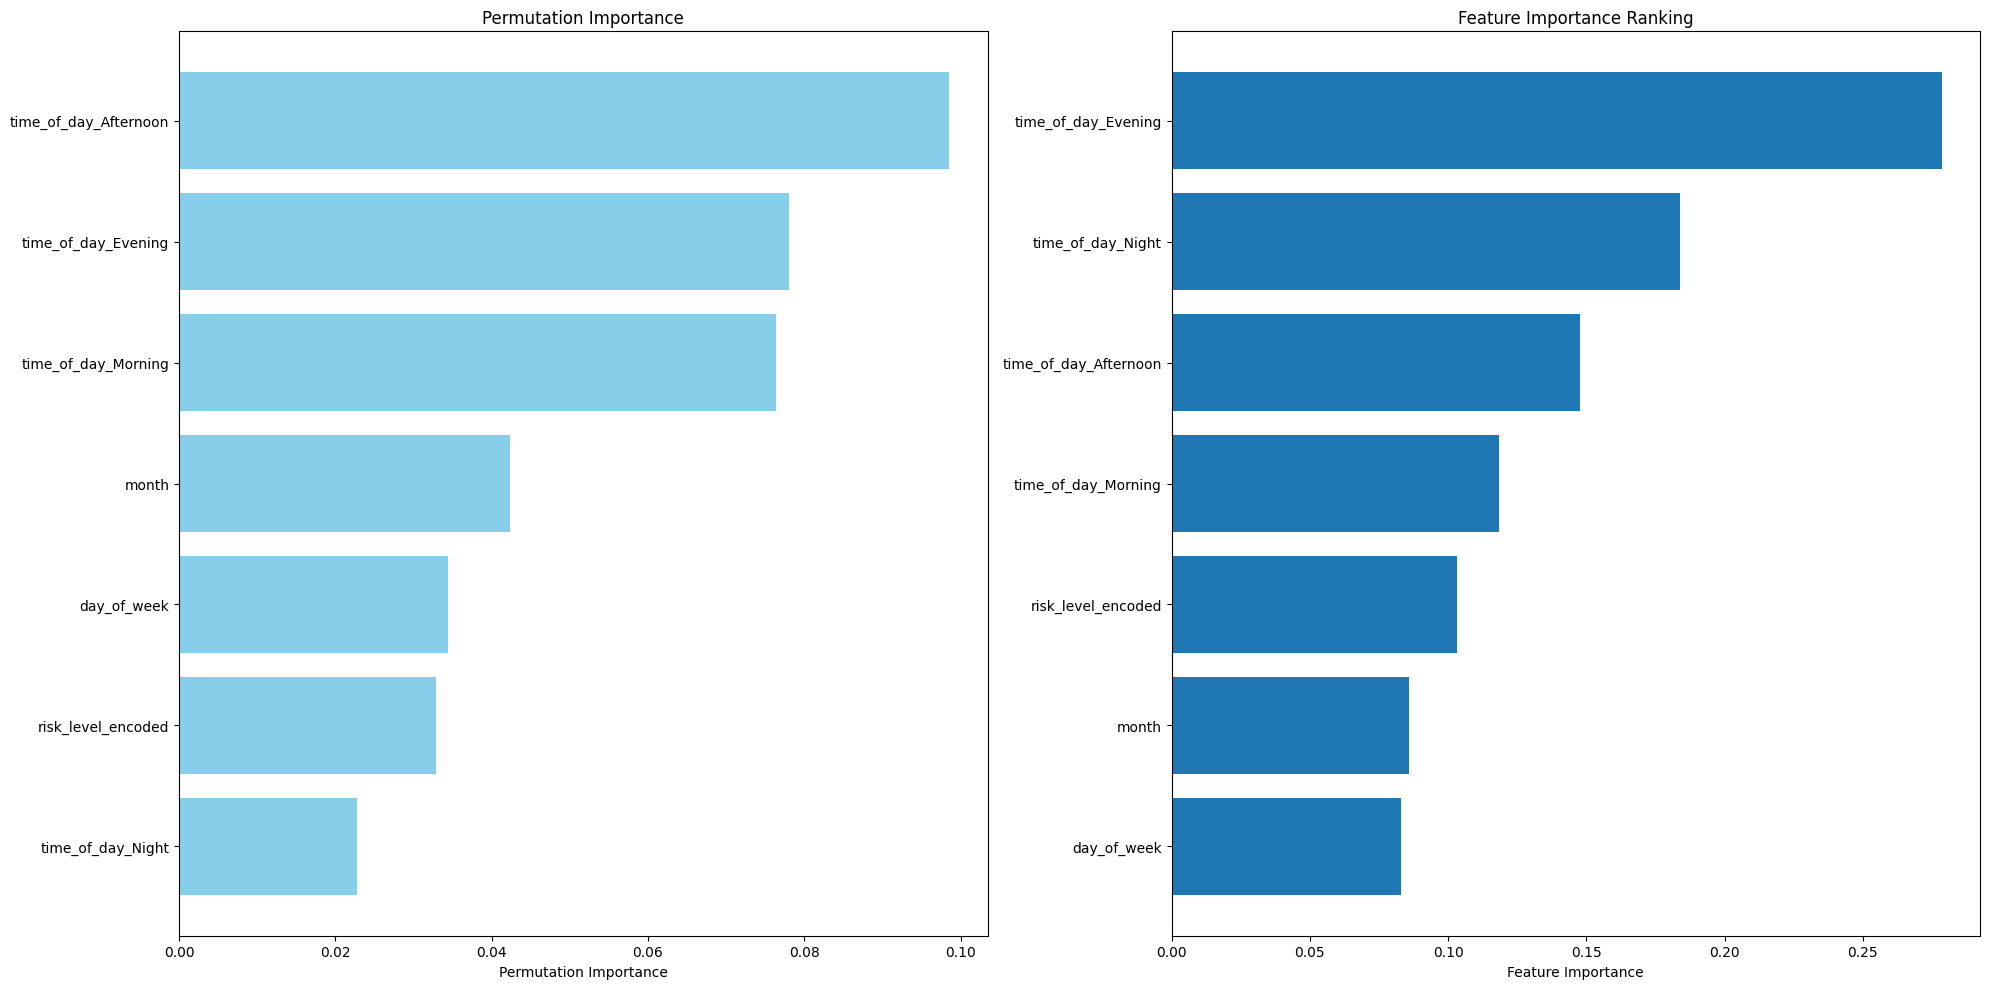

In [50]:
from sklearn.inspection import permutation_importance
feature_importance = risk_level_model_no_lat_lon.feature_importances_

r_train = permutation_importance(risk_level_model_no_lat_lon, X_train, y_train, n_repeats=30, random_state=42)
xbm_p_imp = pd.Series(index=X.columns, data=r_train.importances_mean)

sorted_idx = r_train.importances_mean.argsort()

# Assuming X_train.columns and feature importance arrays are defined
sorted_idx_perm = np.argsort(r_train.importances_mean)
sorted_idx_feat = np.argsort(feature_importance)

# Create subplots: 1 row, 2 columns
fig, axes = plt.subplots(1, 2, figsize=(20, 10))  # Adjust figure size as needed

# First plot: Permutation Importance
axes[0].barh(X_train.columns[sorted_idx_perm], r_train.importances_mean[sorted_idx_perm], color="skyblue")
axes[0].set_xlabel("Permutation Importance")
axes[0].set_title("Permutation Importance")

# Second plot: Feature Importance
axes[1].barh(X_train.columns[sorted_idx_feat], feature_importance[sorted_idx_feat])
axes[1].set_xlabel("Feature Importance")
axes[1].set_title("Feature Importance Ranking")

# Adjust layout for readability
plt.tight_layout()
plt.show()


In [ ]:
# Fits the explainer
explainer = shap.Explainer(shap_xgb_model.predict, X_test_res)
# Calculates the SHAP values - It takes some time
shap_values = explainer(X_test_res)